<a href="https://colab.research.google.com/github/corneliarsm/Covid_Xray_Detection/blob/master/XrayCovid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"corneliarsm","key":"3f60e7307c1d5cbc284d13d88fceb7c3"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                           title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge             COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-06-01 21:47:16          71785  
roche-data-science-coalition/uncover                          UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53          10483  
stefanlarson/outofscope-intent-classification-dataset         Out-of-Scope Intent Classification Dataset          285KB  2020-05-15 03:04:34              1  
rmjacobsen/property-listings-for-5-south-american-countries   Property Listings for 5 South American Countries    475MB  2020-05-25 02:05:38              1  
devinaconley/covid19-mobility-data                  

In [4]:
import tensorflow as tf
assert tf.__version__.startswith('2')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.2.0'

In [5]:
#Download from Kaggle
! kaggle datasets download -d techsash/waste-classification-data --force

 99% 425M/427M [00:05<00:00, 103MB/s] 
100% 427M/427M [00:05<00:00, 85.7MB/s]


In [0]:
#Unzip
import zipfile

zipfile = zipfile.ZipFile("/content/waste-classification-data.zip", 'r')
zipfile.extractall("/content/waste")
zipfile.close()

In [9]:
#Check File
!ls /content/waste/DATASET

#NonAugmentedTrain  TrainData  ValData

TEST  TRAIN


In [10]:
#Remove 
!rm -rf /content/waste/dataset
!ls /content/waste/DATASET/TRAIN

#BacterialPneumonia  COVID-19  Normal  ViralPneumonia

O  R


In [0]:
TRAINING_DIR = "/content/waste/DATASET/TRAIN/"
VALIDATION_DIR = "/content/waste/DATASET/TEST/"

In [12]:
#ImageData Generator
batch_size = 128
image_size=224
training_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      horizontal_flip=True,
      shear_range = 0.2,
      fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(
      rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(image_size,image_size),
	class_mode='binary',
  batch_size=batch_size
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(image_size,image_size),
	class_mode='binary',
  batch_size=batch_size
)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [13]:
#Get Size train_generator and validation_generator
train_num = train_generator.samples
valid_num = validation_generator.samples

print(train_num)
print(valid_num)

22564
2513


In [14]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((128, 224, 224, 3), (128,))

In [15]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'O': 0, 'R': 1}


In [16]:
!cat labels.txt

O
R

In [17]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
base_model.trainable = False

In [0]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(4, activation='softmax')
])

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 2,626,788
Trainable params: 368,804
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [25]:
epochs = 4

history = model.fit(train_generator, 
                    epochs=epochs, 
                    steps_per_epoch=train_num//batch_size, 
                    validation_data = validation_generator,
                    validation_steps=valid_num//batch_size)

Epoch 1/4
176/176 [==============================] - 1039s 6s/step - loss: 0.8211 - accuracy: 0.5305 - val_loss: 0.7719 - val_accuracy: 0.5592
Epoch 2/4
176/176 [==============================] - 1038s 6s/step - loss: 0.7743 - accuracy: 0.5568 - val_loss: 0.7756 - val_accuracy: 0.5555
Epoch 3/4
176/176 [==============================] - 1036s 6s/step - loss: 0.7743 - accuracy: 0.5383 - val_loss: 0.7724 - val_accuracy: 0.4412
Epoch 4/4
176/176 [==============================] - 1033s 6s/step - loss: 0.7739 - accuracy: 0.4425 - val_loss: 0.7769 - val_accuracy: 0.4453


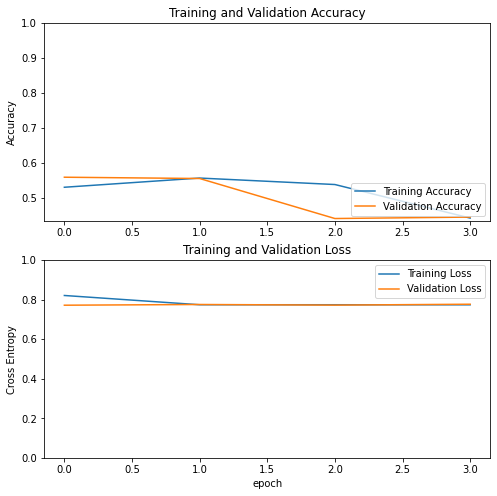

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()